In [1]:
# Generative Adversarial Networks (GAN) example in PyTorch.
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

device = torch.device('cuda')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

/home/2136420/envs/pytorch/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/2136420/envs/pytorch/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/2136420/envs/pytorch/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/2136420/envs/pytorch/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/2136420/envs/pytorch/lib/python2.7/site-packages/pandas/c

In [2]:
# Data params
data_mean = 1
data_stddev = 1.5

In [3]:
# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 20000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [4]:
# ### Uncomment only one of these
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))

Using data [Data and variances]


In [5]:
# ##### DATA: Target data and generator input data
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

In [8]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

In [9]:
d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [10]:
df = pd.DataFrame(columns=['epoch', 'real_error', 'fake_error', 'g_error', 'real_mean', 'real_std', 'fake_mean', 'fake_std'])
d_real_output = []
d_fake_output = []

In [11]:
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(d_sampler(d_input_size))
        p = preprocess(d_real_data)
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

    if epoch % print_interval == 0:
        print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))
        df.loc[epoch / print_interval] = [epoch,
                     extract(d_real_error)[0],
                     extract(d_fake_error)[0],
                     extract(g_error)[0],
                     stats(extract(d_real_data))[0],
                     stats(extract(d_real_data))[1],
                     stats(extract(d_fake_data))[0],
                     stats(extract(d_fake_data))[1]]
        # save dists
        d_real_output.append(extract(d_real_data))
        d_fake_output.append(extract(d_fake_data))


/home/2136420/envs/pytorch/lib/python2.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/2136420/envs/pytorch/lib/python2.7/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D: 0.605687379837/0.659008681774 G: 0.728863835335 (Real: [0.7598753695655615, 1.3707921802286263], Fake: [0.13410257287323474, 0.008100701914571896]) 
200: D: 4.22009798058e-05/0.695339560509 G: 0.705418586731 (Real: [0.8864523467980325, 1.5604896592696567], Fake: [0.14571089506149293, 0.0199318093513481]) 
400: D: 1.96697255888e-05/0.290773570538 G: 1.36464810371 (Real: [1.1894334703695495, 1.3846435641215407], Fake: [-0.004035443887114525, 0.046493924514643806]) 
600: D: 8.16616957309e-05/0.266821950674 G: 1.51177060604 (Real: [0.7928299950412474, 1.2885463264052641], Fake: [0.11044487837702036, 0.11579134725963976]) 
800: D: 9.96639355435e-05/0.104352608323 G: 2.34512615204 (Real: [1.285870892331004, 1.4362150336463926], Fake: [0.4413419736176729, 0.24895594699580278]) 
1000: D: 0.0834946483374/0.0326518975198 G: 2.63417887688 (Real: [0.7045715267956257, 1.3095027611798322], Fake: [0.3606487814337015, 0.4984170753707988]) 
1200: D: 0.328882336617/0.0989447236061 G: 2.66301655769

10800: D: 0.200211122632/1.03533029556 G: 1.24410307407 (Real: [0.7144108285568654, 1.4045547253438266], Fake: [0.8524526010453701, 1.5354982578341394]) 
11000: D: 1.27600562572/0.383040755987 G: 1.28540945053 (Real: [0.6955050136893988, 1.6866153653727125], Fake: [0.9955906976759433, 1.5229653859425827]) 
11200: D: 0.510285615921/0.569171130657 G: 0.99515414238 (Real: [1.2114519394189118, 1.577663896177027], Fake: [1.0445172860473395, 1.4263705066112253]) 
11400: D: 0.189602151513/0.362913519144 G: 2.27700638771 (Real: [0.9675533610582352, 1.7112018726094398], Fake: [1.2740564133040606, 1.373336772665148]) 
11600: D: 0.0352006144822/0.535642206669 G: 1.97182500362 (Real: [1.0749441282637417, 1.6282664945022585], Fake: [1.255885235965252, 1.3630214878420943]) 
11800: D: 0.239000946283/0.0315247029066 G: 1.34857904911 (Real: [1.0707374381273984, 1.4989984896736666], Fake: [0.8714402735233306, 1.772816052419463]) 
12000: D: 0.263301968575/0.830766439438 G: 3.94252038002 (Real: [0.9305624

In [12]:
import matplotlib.pyplot as plt

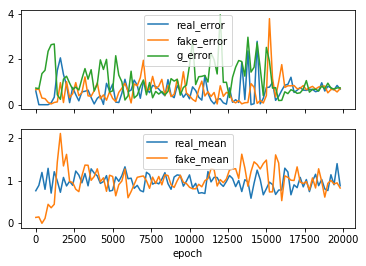

In [13]:
fig, axs = plt.subplots(2,1, sharex = True)
axs = axs.ravel()
df.plot('epoch', 'real_error', ax=axs[0])
df.plot('epoch', 'fake_error', ax=axs[0])
df.plot('epoch', 'g_error', ax = axs[0])

df.plot('epoch', 'real_mean', ax = axs[1])
df.plot('epoch', 'fake_mean', ax = axs[1])

In [ ]:
Nplots = int(np.ceil(np.sqrt(len(d_real_output))))
print(Nplots)
fig, axs = plt.subplots(Nplots,Nplots, sharex=True, sharey=True, figsize=(16, 16))
axs = axs.ravel()
for i in range(len(d_real_output)):
    axs[i].hist(d_real_output[i], alpha = 0.5)
    axs[i].hist(d_fake_output[i], alpha = 0.5)
plt.show()

10
